In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from string import ascii_lowercase
import matplotlib.pyplot as plt

In [2]:
from sustainabilitygame import *


In [37]:
agents = []
# Let's add 10 unsustainable agents
agents.extend([UnsustainableAgent(id=f'u{i}') for i in range(1)])
# Let's add 5 sustainable agents
agents.extend([SustainableAgent(id=f's{i}') for i in range(500)])
# Let's add 5 random agents
agents.extend([RandomChoiceAgent(id=f'r{i}') for i in range(5)])

agents

[Agent u0
   Points: 0,
 Agent s0
   Points: 0,
 Agent s1
   Points: 0,
 Agent s2
   Points: 0,
 Agent s3
   Points: 0,
 Agent s4
   Points: 0,
 Agent s5
   Points: 0,
 Agent s6
   Points: 0,
 Agent s7
   Points: 0,
 Agent s8
   Points: 0,
 Agent s9
   Points: 0,
 Agent s10
   Points: 0,
 Agent s11
   Points: 0,
 Agent s12
   Points: 0,
 Agent s13
   Points: 0,
 Agent s14
   Points: 0,
 Agent s15
   Points: 0,
 Agent s16
   Points: 0,
 Agent s17
   Points: 0,
 Agent s18
   Points: 0,
 Agent s19
   Points: 0,
 Agent s20
   Points: 0,
 Agent s21
   Points: 0,
 Agent s22
   Points: 0,
 Agent s23
   Points: 0,
 Agent s24
   Points: 0,
 Agent s25
   Points: 0,
 Agent s26
   Points: 0,
 Agent s27
   Points: 0,
 Agent s28
   Points: 0,
 Agent s29
   Points: 0,
 Agent s30
   Points: 0,
 Agent s31
   Points: 0,
 Agent s32
   Points: 0,
 Agent s33
   Points: 0,
 Agent s34
   Points: 0,
 Agent s35
   Points: 0,
 Agent s36
   Points: 0,
 Agent s37
   Points: 0,
 Agent s38
   Points: 0,
 Agent s39


In [38]:
env = Environment(label="E")
env

Environment E
  State: 1.00

In [39]:
pop = Population(agents=agents, environment=env, label="P")
pop


Population P
  506 agents
  Total points: 0
  t = 0
  Environment: E

In [40]:
T = 1000  # Number of rounds
for t in range(T):
    pop.progress()
    print(t)
    print(pop)
    print(env)

0
Population P
  506 agents
  Total points: 23.18263018396019
  t = 1
  Environment: E
Environment E
  State: 0.91
1
Population P
  506 agents
  Total points: 46.87733164338027
  t = 2
  Environment: E
Environment E
  State: 0.90
2
Population P
  506 agents
  Total points: 69.91517129270424
  t = 3
  Environment: E
Environment E
  State: 0.89
3
Population P
  506 agents
  Total points: 93.4761783232166
  t = 4
  Environment: E
Environment E
  State: 0.92
4
Population P
  506 agents
  Total points: 116.14801737278538
  t = 5
  Environment: E
Environment E
  State: 0.82
5
Population P
  506 agents
  Total points: 135.95447712156476
  t = 6
  Environment: E
Environment E
  State: 0.78
6
Population P
  506 agents
  Total points: 155.26739376906602
  t = 7
  Environment: E
Environment E
  State: 0.69
7
Population P
  506 agents
  Total points: 172.684360412694
  t = 8
  Environment: E
Environment E
  State: 0.71
8
Population P
  506 agents
  Total points: 190.95066502705586
  t = 9
  Enviro

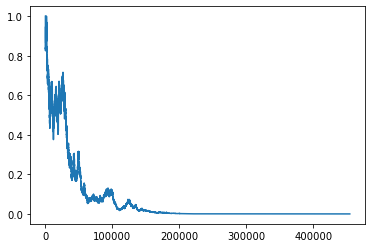

In [41]:
plt.plot(env.state_history)

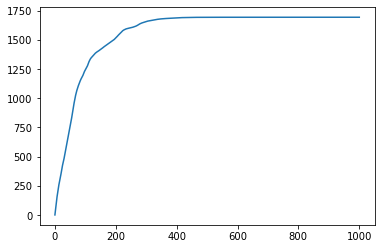

In [42]:
plt.plot(pop.total_points_history)